In [20]:
import os

dataset_path = r"V:\Hypergraphs\img_resized"
print("Files in dataset:", os.listdir(dataset_path)[:10])


Files in dataset: ['1023940590382268417.jpg', '1023940826882293760.jpg', '1023940897346658307.jpg', '1023942214844657664.jpg', '1023942220838264837.jpg', '1023942343202881536.jpg', '1023943177319919616.jpg', '1023943945670148096.jpg', '1023943955023519744.jpg', '1023944988365709312.jpg']


In [4]:
!pip install opencv-python

You should consider upgrading via the 'C:\Users\vivek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


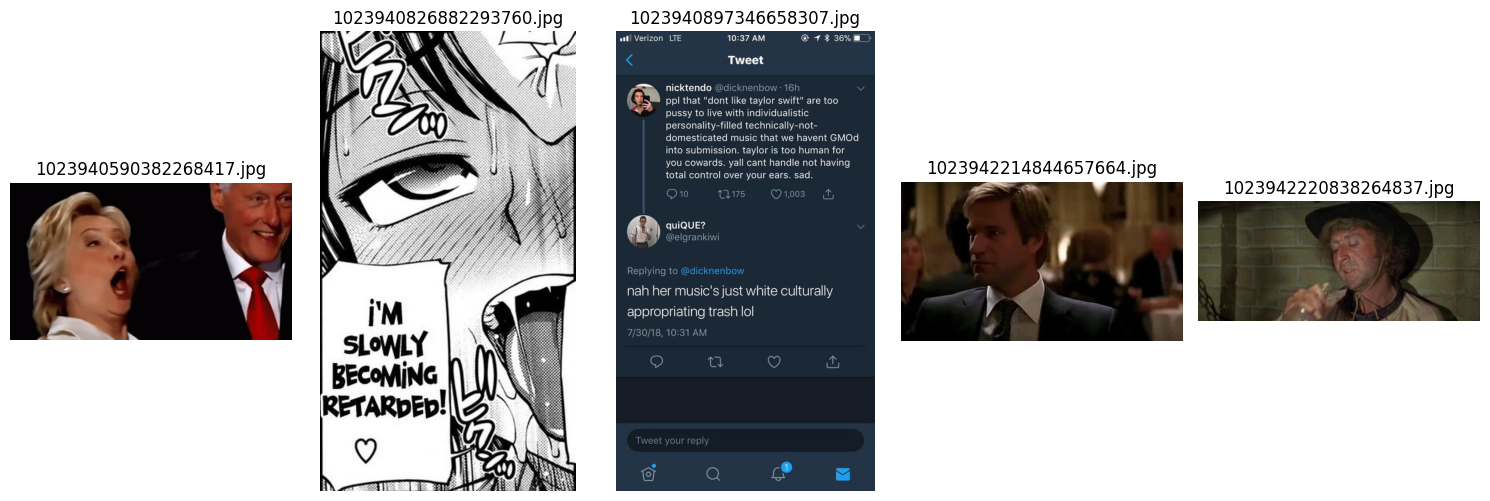

In [21]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to your dataset folder in D drive
dataset_path = r"V:\Hypergraphs\img_resized"

# Get list of first 5 image files
image_files = sorted([f for f in os.listdir(dataset_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])[:5]

# Check if images exist
if not image_files:
    print("No image files found in the directory!")
else:
    # Plot first 5 images
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(dataset_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(1, 5, i + 1)  # 1 row, 5 columns
        plt.imshow(img)
        plt.title(img_name[:30])  # Show truncated name
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [22]:
# Define paths
DATA_ROOT = r"V:\Hypergraphs"
IMG_DIR = os.path.join(DATA_ROOT, 'img_resized')
GT_FILE = os.path.join(DATA_ROOT, 'MMHS150K_GT.json')
TRAIN_IDS = os.path.join(DATA_ROOT, 'splits', 'train_ids.txt')
VAL_IDS = os.path.join(DATA_ROOT, 'splits', 'val_ids.txt')
TEST_IDS = os.path.join(DATA_ROOT, 'splits', 'test_ids.txt')

In [23]:
import json
def load_ground_truth():
    """Load the ground truth JSON file with metadata and labels."""
    with open(GT_FILE, 'r') as f:
        gt_data = json.load(f)
    return gt_data

def load_ids_from_file(file_path):
    """Load image IDs from a file."""
    with open(file_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

# Load ground truth data
gt_data = load_ground_truth()
print(f"Total number of samples: {len(gt_data)}")

Total number of samples: 149823


In [24]:
# Display a few examples
for idx, (img_id, metadata) in enumerate(list(gt_data.items())[:5]):
    print(f"\nExample {idx+1}:")
    print(f"Image ID: {img_id}")
    print(f"Labels: {metadata['labels']} ({metadata['labels_str']})")
    print(f"Tweet Text: {metadata['tweet_text']}")


Example 1:
Image ID: 1114679353714016256
Labels: [4, 1, 3] (['Religion', 'Racist', 'Homophobe'])
Tweet Text: @FriskDontMiss Nigga https://t.co/cAsaLWEpue

Example 2:
Image ID: 1063020048816660480
Labels: [5, 5, 5] (['OtherHate', 'OtherHate', 'OtherHate'])
Tweet Text: My horses are retarded https://t.co/HYhqc6d5WN

Example 3:
Image ID: 1108927368075374593
Labels: [0, 0, 0] (['NotHate', 'NotHate', 'NotHate'])
Tweet Text: “NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL SHIT NIGGA” https://t.co/UczofqHrLq

Example 4:
Image ID: 1114558534635618305
Labels: [1, 0, 0] (['Racist', 'NotHate', 'NotHate'])
Tweet Text: RT xxSuGVNGxx: I ran into this HOLY NIGGA TODAY 😭😭😭😭 https://t.co/Wa6Spl9kIw

Example 5:
Image ID: 1035252480215592966
Labels: [1, 0, 1] (['Racist', 'NotHate', 'Racist'])
Tweet Text: “EVERYbody calling you Nigger now!” https://t.co/6mguJ6KIBF


In [25]:
# Load dataset splits
train_ids = load_ids_from_file(TRAIN_IDS)
val_ids = load_ids_from_file(VAL_IDS)
test_ids = load_ids_from_file(TEST_IDS)

print(f"Train set size: {len(train_ids)}")
print(f"Validation set size: {len(val_ids)}")
print(f"Test set size: {len(test_ids)}")

Train set size: 134823
Validation set size: 5000
Test set size: 10000


In [26]:
# Count label distribution in the original data
label_distribution = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for metadata in gt_data.values():
    # Get majority vote for each sample
    labels = metadata['labels']
    majority_label = max(set(labels), key=labels.count)
    label_distribution[majority_label] += 1

print("Original label distribution (majority vote):")
label_names = ["NotHate", "Racist", "Sexist", "Homophobe", "Religion", "OtherHate"]
for label_idx, count in label_distribution.items():
    percentage = count / len(gt_data) * 100
    print(f"{label_names[label_idx]} ({label_idx}): {count} ({percentage:.2f}%)")

Original label distribution (majority vote):
NotHate (0): 124003 (82.77%)
Racist (1): 12288 (8.20%)
Sexist (2): 3671 (2.45%)
Homophobe (3): 3886 (2.59%)
Religion (4): 164 (0.11%)
OtherHate (5): 5811 (3.88%)


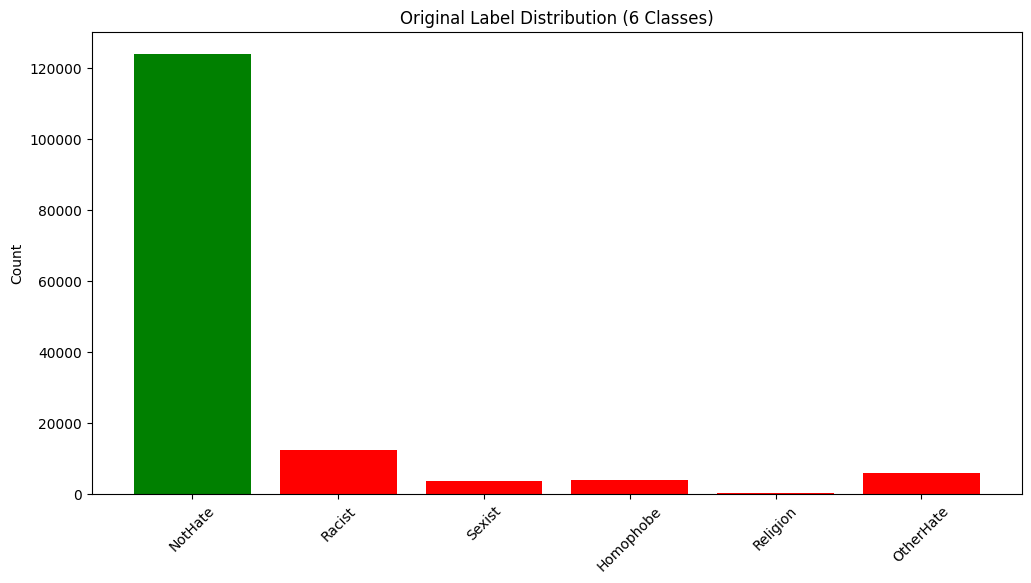

In [27]:
# Plot the original label distribution
plt.figure(figsize=(12, 6))
plt.bar(label_names, [label_distribution[i] for i in range(6)], 
       color=['green', 'red', 'red', 'red', 'red', 'red'])
plt.title('Original Label Distribution (6 Classes)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [28]:
def convert_to_binary(labels):
    """
    Convert the 6-class labels to binary labels.
    
    Args:
        labels: List of original labels (0-5)
        
    Returns:
        Binary label (0 for NotHate, 1 for Hate)
    """
    # For each annotator's label, convert to binary (0 remains 0, 1-5 become 1)
    binary_labels = [1 if label > 0 else 0 for label in labels]
    
    # Take majority vote for the final label
    return round(sum(binary_labels) / len(binary_labels))

# Process all data and create a binary label mapping
binary_labels = {}
for img_id, metadata in gt_data.items():
    binary_labels[img_id] = convert_to_binary(metadata['labels'])

# Count the distribution of binary labels
label_counts = {0: 0, 1: 0}
for label in binary_labels.values():
    label_counts[label] += 1

print("Binary label distribution:")
print(f"NotHate (0): {label_counts[0]} ({label_counts[0]/len(binary_labels)*100:.2f}%)")
print(f"Hate (1): {label_counts[1]} ({label_counts[1]/len(binary_labels)*100:.2f}%)")

Binary label distribution:
NotHate (0): 112858 (75.33%)
Hate (1): 36965 (24.67%)


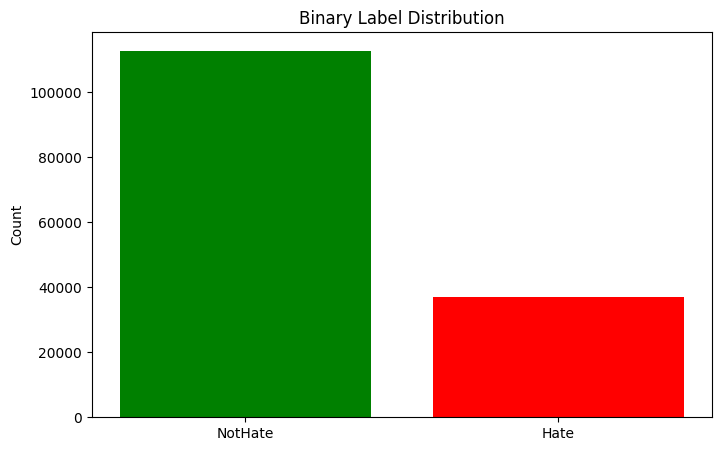

In [29]:
# Plot the binary label distribution
plt.figure(figsize=(8, 5))
binary_labels_names = ['NotHate', 'Hate']
counts = [label_counts[0], label_counts[1]]
plt.bar(binary_labels_names, counts, color=['green', 'red'])
plt.title('Binary Label Distribution')
plt.ylabel('Count')
plt.show()


In [30]:
# Save binary labels to a file
with open('binary_labels.json', 'w') as f:
    json.dump(binary_labels, f)

print("Binary labels saved to binary_labels.json")

Binary labels saved to binary_labels.json


In [31]:
def load_binary_labels(json_path='binary_labels.json'):
    """Load binary labels from a JSON file."""
    with open(json_path, 'r') as f:
        binary_labels = json.load(f)
    return binary_labels

In [32]:
from tensorflow.keras.utils import Sequence  # <-- Add this line

class MMHS150KSequence(Sequence):
    """Custom data generator for the MMHS150K dataset."""
    
    def __init__(self, img_dir, binary_labels, img_ids, batch_size=32, 
                 img_size=(224, 224), shuffle=True):
        """
        Initialize the data generator.
        
        Args:
            img_dir (str): Directory with all the images
            binary_labels (dict): Dictionary mapping image IDs to binary labels
            img_ids (list): List of image IDs to include in this dataset
            batch_size (int): Batch size
            img_size (tuple): Target image size (height, width)
            shuffle (bool): Whether to shuffle the data after each epoch
        """
        self.img_dir = img_dir
        self.binary_labels = binary_labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        
        # Filter to include only images that exist
        self.valid_img_ids = []
        for img_id in img_ids:
            if img_id in binary_labels and os.path.exists(os.path.join(img_dir, f"{img_id}.jpg")):
                self.valid_img_ids.append(img_id)
        
        print(f"Found {len(self.valid_img_ids)} valid images out of {len(img_ids)} IDs")
        
        # Create indices and shuffle if needed
        self.indices = np.arange(len(self.valid_img_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        """Return the number of batches per epoch."""
        return int(np.ceil(len(self.valid_img_ids) / self.batch_size))
    
    def __getitem__(self, idx):
        """Get batch at index idx."""
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Initialize batch arrays
        batch_x = np.zeros((len(batch_indices), self.img_size[0], self.img_size[1], 3), dtype=np.float32)
        batch_y = np.zeros(len(batch_indices), dtype=np.int32)
        batch_ids = []
        
        # Load and preprocess images
        for i, idx in enumerate(batch_indices):
            img_id = self.valid_img_ids[idx]
            img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
            
            try:
                # Load and preprocess image
                img = Image.open(img_path).convert('RGB')
                img = img.resize(self.img_size)
                img_array = img_to_array(img)
                
                # Preprocess for the appropriate model
                # For ResNet: normalize with the ImageNet statistics
                img_array = img_array / 255.0
                img_array = (img_array - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
                
                batch_x[i] = img_array
                batch_y[i] = self.binary_labels[img_id]
                batch_ids.append(img_id)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                # Use zeros for failed images
                batch_x[i] = np.zeros((self.img_size[0], self.img_size[1], 3))
                batch_y[i] = self.binary_labels[img_id]  # Use label anyway
                batch_ids.append(img_id)
        
        return batch_x, batch_y, batch_ids
    
    def on_epoch_end(self):
        """Called at the end of each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def get_sample(self, idx):
        """Get a single sample for visualization."""
        img_id = self.valid_img_ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        try:
            # Load image
            img = Image.open(img_path).convert('RGB')
            img = img.resize(self.img_size)
            img_array = img_to_array(img)
            
            # Normalize the image (for visualization)
            img_array = img_array / 255.0
            
            # Get label
            label = self.binary_labels[img_id]
            
            return img_array, label, img_id
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return np.zeros((self.img_size[0], self.img_size[1], 3)), self.binary_labels[img_id], img_id

In [33]:
train_ids = sorted([f.split('.')[0] for f in os.listdir(IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])[:1000]

print(f"Selected {len(train_ids)} images for training.")

Selected 1000 images for training.


In [34]:
import numpy as np
# Create a sample data generator with a subset of train images
sample_train_ids = train_ids[:1000]  # Use a small subset for faster processing
sample_generator = MMHS150KSequence(IMG_DIR, binary_labels, sample_train_ids, batch_size=32)

Found 1000 valid images out of 1000 IDs


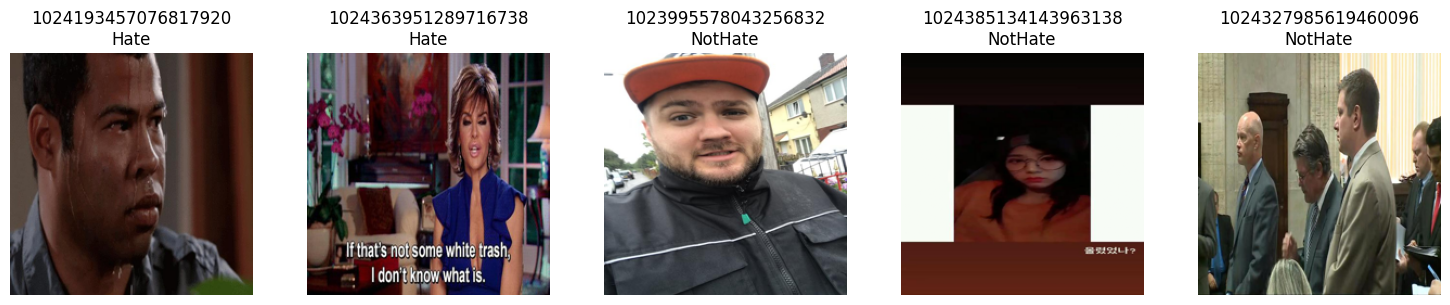

In [35]:
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

def visualize_samples(data_generator, num_samples=3):
    """
    Visualize random samples from the dataset.
    
    Args:
        data_generator (MMHS150KSequence): Data generator
        num_samples (int): Number of samples to visualize
    """
    # Create a figure
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    # Generate random indices
    indices = np.random.choice(len(data_generator.valid_img_ids), num_samples, replace=False)
    
    # Display each image
    for i, idx in enumerate(indices):
        img_array, label, img_id = data_generator.get_sample(idx)
        
        axes[i].imshow(img_array)
        axes[i].set_title(f"{img_id}\n{'Hate' if label == 1 else 'NotHate'}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some samples
visualize_samples(sample_generator, num_samples=5)

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16, MobileNetV2
from tensorflow.keras.models import Model

def get_feature_extractor(model_name='resnet50', img_size=(224, 224)):
    """
    Create a feature extractor from a pre-trained CNN model.
    
    Args:
        model_name (str): Name of the model to use
        img_size (tuple): Input image size (height, width)
        
    Returns:
        Model: Feature extractor model
    """
    # Dictionary of available models
    models_dict = {
        'resnet50': ResNet50,
        'resnet101': ResNet101,
        'efficientnet_b0': EfficientNetB0,
        'vgg16': VGG16,
        'mobilenet_v2': MobileNetV2
    }
    
    # Ensure valid model name
    if model_name not in models_dict:
        raise ValueError(f"Unsupported model: {model_name}. Choose from {list(models_dict.keys())}")

    # Load the base model with pretrained ImageNet weights
    base_model = models_dict[model_name](
        weights='imagenet', 
        include_top=False, 
        input_shape=(img_size[0], img_size[1], 3)
    )
    
    # Prevent training for efficiency
    base_model.trainable = False

    # Add global average pooling to get a single feature vector per image
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

    # Create the feature extractor model
    feature_extractor = Model(inputs=base_model.input, outputs=x, name=f"{model_name}_feature_extractor")

    return feature_extractor


In [37]:
# Create feature extractor
model_name = 'resnet50'  # You can change this to 'resnet101' or 'efficientnet_b0'
img_size = (224, 224)
feature_extractor = get_feature_extractor(model_name=model_name, img_size=img_size)
print(f"Using {model_name} as feature extractor")

Using resnet50 as feature extractor


In [38]:
def extract_features(data_generator, feature_extractor):
    """
    Extract features from images using a pre-trained model.
    
    Args:
        data_generator (MMHS150KSequence): Data generator
        feature_extractor (Model): Feature extractor model
        
    Returns:
        tuple: (features, labels, img_ids)
    """
    features = []
    labels = []
    img_ids = []
    
    for i in tqdm(range(len(data_generator)), desc="Extracting features"):
        batch_imgs, batch_labels, batch_ids = data_generator[i]
        
        # Extract features
        batch_features = feature_extractor.predict(batch_imgs, verbose=0)
        
        # Store results
        features.append(batch_features)
        labels.extend(batch_labels)
        img_ids.extend(batch_ids)
    
    # Concatenate features
    features = np.vstack(features)
    
    return features, np.array(labels), img_ids

In [39]:
from tqdm import tqdm

# Extract features from the sample dataset
sample_features, sample_labels, sample_img_ids = extract_features(sample_generator, feature_extractor)
print(f"Extracted features shape: {sample_features.shape}")

Extracting features: 100%|█████████████████████████████████████████████████████████████| 32/32 [01:12<00:00,  2.27s/it]

Extracted features shape: (1000, 2048)


In [26]:
!pip install torch torchvision torchaudio

You should consider upgrading via the 'C:\Users\vivek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [40]:
import torch

# Convert extracted features to PyTorch tensor
sample_features_torch = torch.tensor(sample_features, dtype=torch.float32)
sample_labels_torch = torch.tensor(sample_labels, dtype=torch.long)  # If labels are integers

# Print shapes to confirm
print(f"Feature tensor shape: {sample_features_torch.shape}")  
print(f"Labels tensor shape: {sample_labels_torch.shape}")  

Feature tensor shape: torch.Size([1000, 2048])
Labels tensor shape: torch.Size([1000])


In [29]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=183f97731876cb7ce682f2e4fbda7bfb7f9238721451c048371294063a5eff64
  Stored in directory: c:\users\vivek\appdata\local\pip\cache\wheels\9b\13\01\6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\vivek\AppData\Local\Programs\Python\Python310\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\vivek\\AppData\\Local\\Temp\\pip-install-79l7epco\\sklearn_dc9f9c38d94a40629301ecf2782964c8\\setup.py'"'"'; __file__='"'"'C:\\Users\\vivek\\AppData\\Local\\Temp\\pip-install-79l7epco\\sklearn_dc9f9c38d94a40629301ecf2782964c8\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\vivek\AppData\Local\Temp\pip-pip-egg-info-339u__tn'
         cwd: C:\Users\vivek\AppData\Local\Temp\pip-install-79l7epco\sklearn_dc9f9c38d94a40629301ecf2782964c8\
    Complete output (15 lines):
    The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  

In [41]:
import torch
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
import numpy as np

def build_knn_hypergraph(features, k=5):
    """
    Construct hyperedges using k-Nearest Neighbors (k-NN).
    
    Args:
        features (torch.Tensor): Tensor of shape (N, D) where N is the number of images, D is the feature dimension.
        k (int): Number of neighbors to connect per node.
    
    Returns:
        torch.Tensor: Hypergraph incidence matrix H of shape (N, E), where E is the number of hyperedges.
    """
    N = features.shape[0]
    features_np = features.cpu().numpy()  # Convert to NumPy for k-NN computation
    
    # Compute k-NN graph
    knn = NearestNeighbors(n_neighbors=k + 1, metric='cosine').fit(features_np)
    neighbors = knn.kneighbors(features_np, return_distance=False)
    
    # Create hyperedges (excluding self-loops)
    hyperedges = []
    for i in range(N):
        hyperedges.append(set(neighbors[i][1:]))  # Exclude self (first entry is the node itself)
    
    # Convert to hypergraph incidence matrix (N x E)
    num_hyperedges = len(hyperedges)
    H = torch.zeros((N, num_hyperedges), dtype=torch.float32)
    
    for e, nodes in enumerate(hyperedges):
        for node in nodes:
            H[node, e] = 1.0  # Assign weight 1 to hyperedges
    
    return H

# Example usage:
k = 5  # Number of neighbors per node
H = build_knn_hypergraph(sample_features_torch, k)
print(f"Hypergraph Incidence Matrix Shape: {H.shape}")  # Should be (N, E)

Hypergraph Incidence Matrix Shape: torch.Size([1000, 1000])


In [31]:
!pip install torch_geometric


You should consider upgrading via the 'C:\Users\vivek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

class HypergraphNeuralNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super(HypergraphNeuralNetwork, self).__init__()

        # Hypergraph convolution layers
        self.hgconv1 = HypergraphConv(in_dim, hidden_dim)
        self.hgconv2 = HypergraphConv(hidden_dim, out_dim)

        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = F.relu(self.hgconv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.hgconv2(x, edge_index)
        return x

# Convert hypergraph incidence matrix (H) to edge_index format for PyTorch Geometric
edge_index = H.nonzero().t().contiguous()

# Create hypergraph data object
data = Data(x=sample_features_torch, edge_index=edge_index, y=sample_labels_torch)

# Define HGNN model
in_dim = sample_features_torch.shape[1]  # 2048 (ResNet50 features)
hidden_dim = 1024  # Increased hidden dimension
out_dim = len(torch.unique(sample_labels_torch))  # Number of classes
hgnn = HypergraphNeuralNetwork(in_dim, hidden_dim, out_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(hgnn.parameters(), lr=0.0005, weight_decay=1e-4)  # Reduced learning rate

# Create DataLoader
dataset = TensorDataset(sample_features_torch, sample_labels_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
def train_hgnn(model, dataloader, criterion, optimizer, data, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_acc = 0
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(data.x, data.edge_index)  # Use full graph structure
            loss = criterion(outputs, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Compute accuracy
            pred_labels = torch.argmax(outputs, dim=1)
            acc = (pred_labels == data.y).float().mean().item()
            total_acc += acc
        
        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

# Train the model
train_hgnn(hgnn, dataloader, criterion, optimizer, data)

Epoch 1/10, Loss: 0.8543, Accuracy: 0.5279
Epoch 2/10, Loss: 0.6722, Accuracy: 0.5870
Epoch 3/10, Loss: 0.6550, Accuracy: 0.6097
Epoch 4/10, Loss: 0.6419, Accuracy: 0.6208
Epoch 5/10, Loss: 0.6311, Accuracy: 0.6366
Epoch 6/10, Loss: 0.6228, Accuracy: 0.6442
Epoch 7/10, Loss: 0.6151, Accuracy: 0.6525
Epoch 8/10, Loss: 0.6094, Accuracy: 0.6585
Epoch 9/10, Loss: 0.6046, Accuracy: 0.6626
Epoch 10/10, Loss: 0.5998, Accuracy: 0.6658


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

class HypergraphNeuralNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super(HypergraphNeuralNetwork, self).__init__()

        # Hypergraph convolution layers
        self.hgconv1 = HypergraphConv(in_dim, hidden_dim)
        self.hgconv2 = HypergraphConv(hidden_dim, out_dim)

        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = F.relu(self.hgconv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.hgconv2(x, edge_index)
        return x

# Convert hypergraph incidence matrix (H) to edge_index format for PyTorch Geometric
edge_index = H.nonzero().t().contiguous()

# Create hypergraph data object
data = Data(x=sample_features_torch, edge_index=edge_index, y=sample_labels_torch)

# Split dataset into training (first 800) and validation (next 200)
train_features, val_features = sample_features_torch[:800], sample_features_torch[800:]
train_labels, val_labels = sample_labels_torch[:800], sample_labels_torch[800:]

# Define HGNN model
in_dim = sample_features_torch.shape[1]  # 2048 (ResNet50 features)
hidden_dim = 1024  # Increased hidden dimension
out_dim = len(torch.unique(sample_labels_torch))  # Number of classes
hgnn = HypergraphNeuralNetwork(in_dim, hidden_dim, out_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(hgnn.parameters(), lr=0.0005, weight_decay=1e-4)  # Reduced learning rate

# Create DataLoaders for training and validation
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop with validation
def train_hgnn(model, train_loader, val_loader, criterion, optimizer, data, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_acc = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(data.x, data.edge_index)  # Use full graph structure
            loss = criterion(outputs, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Compute accuracy
            pred_labels = torch.argmax(outputs, dim=1)
            acc = (pred_labels == data.y).float().mean().item()
            total_acc += acc
        
        avg_loss = total_loss / len(train_loader)
        avg_acc = total_acc / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(data.x, data.edge_index)
                loss = criterion(outputs, data.y)
                val_loss += loss.item()
                
                pred_labels = torch.argmax(outputs, dim=1)
                acc = (pred_labels == data.y).float().mean().item()
                val_acc += acc
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

# Train the model
train_hgnn(hgnn, train_dataloader, val_dataloader, criterion, optimizer, data)


Epoch 1/10, Loss: 0.8709, Accuracy: 0.5273
Validation Loss: 0.6885, Validation Accuracy: 0.5260
Epoch 2/10, Loss: 0.6690, Accuracy: 0.5911
Validation Loss: 0.6550, Validation Accuracy: 0.6180
Epoch 3/10, Loss: 0.6495, Accuracy: 0.6200
Validation Loss: 0.6433, Validation Accuracy: 0.6240
Epoch 4/10, Loss: 0.6373, Accuracy: 0.6376
Validation Loss: 0.6303, Validation Accuracy: 0.6420
Epoch 5/10, Loss: 0.6234, Accuracy: 0.6492
Validation Loss: 0.6166, Validation Accuracy: 0.6560
Epoch 6/10, Loss: 0.6111, Accuracy: 0.6624
Validation Loss: 0.6060, Validation Accuracy: 0.6680
Epoch 7/10, Loss: 0.6018, Accuracy: 0.6715
Validation Loss: 0.5974, Validation Accuracy: 0.6760
Epoch 8/10, Loss: 0.5942, Accuracy: 0.6780
Validation Loss: 0.5904, Validation Accuracy: 0.6840
Epoch 9/10, Loss: 0.5877, Accuracy: 0.6845
Validation Loss: 0.5843, Validation Accuracy: 0.6910
Epoch 10/10, Loss: 0.5818, Accuracy: 0.6913
Validation Loss: 0.5786, Validation Accuracy: 0.6900


In [ ]:
#Text Embeddings

In [44]:
import pandas as pd

data = pd.read_csv("textual_data_an1_cleaned_final.csv")

print(data.head())

                                   clean_tweet_2  label
0                                          nigga      4
1                                horses retarded      5
2  nigga momma youngboy spitting real shit nigga      0
3            rt xxsugvngxx ran holy nigga today       1
4                       everybody calling nigger      1


In [2]:
!pip install gensim.models

ERROR: Could not find a version that satisfies the requirement gensim.models (from versions: none)
ERROR: No matching distribution found for gensim.models
You should consider upgrading via the 'C:\Users\vivek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [45]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import nltk
import os

DATA_ROOT = r"V:\Hypergraphs"
DWN_DIR = os.path.join(DATA_ROOT)
# Verify if 'punkt' is available
nltk.download('punkt', download_dir=DWN_DIR)

sentences = data['clean_tweet_2'].dropna().tolist()
#tokenized_sentences = [sentence.split() for sentence in sentences]
tokenizer = RegexpTokenizer(r'\w+')
tokenized_sentences = [tokenizer.tokenize(str(sentence).lower()) for sentence in sentences]

#model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1, epochs=10)

#model.save("word2vec_model.model")

[nltk_data] Downloading package punkt to V:\Hypergraphs...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
model = Word2Vec.load('word2vec_model.model')

word_vector = model.wv['shit']
print("Vector for 'shit':", word_vector)

similar_words = model.wv.most_similar('shit')
print("Words similar to 'shit':", similar_words)

Vector for 'shit': [-1.9590057e-02  4.6684235e-01  7.6496118e-01  7.1472056e-02
  7.4470842e-01 -5.0849015e-01  7.2395462e-01  6.5145570e-01
 -9.7402000e-01 -9.4522440e-01  3.0409154e-01 -8.9401555e-01
 -8.6123921e-02 -1.3225059e-01 -2.1727771e-01  1.5976471e-01
  5.5095989e-01 -3.9442542e-01 -9.4595104e-02 -4.1664425e-01
  6.2709384e-02  2.2566906e-01  4.3575704e-02 -1.8051888e-01
  1.4805755e-01  2.4423726e-01 -3.7822351e-01 -2.5321850e-01
 -5.6976473e-01 -5.5646533e-01 -5.4964959e-03 -1.9575089e-01
 -2.2708194e-01 -8.8444851e-02 -4.9538112e-01  1.2278016e-01
  2.0446534e-01 -5.7703382e-03 -1.6811025e-01 -5.7831174e-01
  2.0288713e-01  6.7173398e-01  2.1752685e-01  2.2173375e-01
  6.0447073e-01 -2.6183934e-03 -3.8476551e-01 -1.7862551e-01
  3.2777292e-01  5.9678084e-01  3.7988600e-01 -1.4047587e-01
 -6.2954897e-01 -1.8691503e-01 -1.0080524e-01  2.6467201e-01
  1.2537839e-01 -4.7455542e-04 -3.8506609e-01  6.9666165e-01
 -5.4413533e-01 -4.0494233e-01  1.5303372e-01 -6.2520456e-01
 -6.9

In [47]:

# Check most similar words
word = "hate"
similar_words = model.wv.most_similar(word, topn=5)
print(f"Words similar to '{word}': {similar_words}")


Words similar to 'hate': [('hates', 0.7087909579277039), ('istg', 0.702265739440918), ('fault', 0.6987146139144897), ('kidnap', 0.692625105381012), ('supportive', 0.6921353340148926)]


In [13]:
model.save("fasttext_model.model")  # Saves full model
model.wv.save("fasttext_model_vectors.kv")  # Saves only word vectors

In [48]:
from gensim.models import FastText

model = FastText.load("fasttext_model.model")

word_vector = model.wv['hate']
print("Vector for 'hate':", word_vector)

similar_words = model.wv.most_similar('hate')
print("Similar words:", similar_words)

Vector for 'hate': [ 8.99812728e-02  2.25138649e-01  5.07408917e-01 -1.19483165e-01
  1.61982864e-01 -4.87406284e-01  6.84463620e-01  9.00936663e-01
 -3.42380345e-01 -2.23101586e-01 -4.85794157e-01 -1.33360624e-01
  8.76871586e-01  2.28884533e-01 -2.70479113e-01  8.18268955e-02
  2.85709232e-01 -5.52754700e-01 -9.79937762e-02 -4.99564588e-01
 -2.88823918e-02  1.66915014e-01  1.51666217e-02 -1.44419417e-01
  9.33396220e-02  1.79245785e-01 -2.36515194e-01  5.03747582e-01
 -2.10705206e-01 -1.95269566e-02 -4.75573808e-01  5.57647869e-02
  8.16497505e-02 -2.11907580e-01 -6.63805604e-01  4.34872329e-01
 -6.83386773e-02  3.21134299e-01 -4.61863011e-01 -7.30429113e-01
  1.99269578e-01 -3.17006141e-01 -1.31294757e-01 -8.62335786e-02
  6.33381069e-01  8.00391950e-04 -8.15152004e-02 -7.38363191e-02
  5.94716132e-01 -1.19548544e-01  2.29647145e-01 -2.45174423e-01
 -3.60608071e-01 -7.74932653e-02  1.80180803e-01 -1.96912050e-01
 -8.11004452e-03 -2.71006465e-01 -3.61491442e-01  5.61406255e-01
 -3.83

In [49]:
import numpy as np
import pandas as pd
from gensim.models import FastText
from scipy.sparse import csr_matrix
from collections import defaultdict

# Load FastText model
model = FastText.load("fasttext_model.model")

# Sample sentences (Ensure they are strings and remove NaN values)
sentences = data['clean_tweet_2']
sentences = [str(sentence) for sentence in sentences if pd.notnull(sentence)]

# Create vocabulary
vocab = list(model.wv.index_to_key)
word_to_index = defaultdict(lambda: -1, {word: i for i, word in enumerate(vocab)})

# Create feature matrix (X) - word embeddings
embedding_dim = model.vector_size
X = np.zeros((len(vocab), embedding_dim), dtype=np.float32)

for i, word in enumerate(vocab):
    X[i] = model.wv[word]

# Convert X to sparse format
X_sparse = csr_matrix(X)

# Construct hypergraph incidence matrix (H) using lists (efficient way)
row_indices = []
col_indices = []
data_values = []

for j, sentence in enumerate(sentences):
    for word in sentence.split():
        i = word_to_index[word]
        if i != -1:
            row_indices.append(i)
            col_indices.append(j)
            data_values.append(1)

# Convert to sparse matrix
H_sparse = csr_matrix((data_values, (row_indices, col_indices)), shape=(len(vocab), len(sentences)))

# Print shapes
print("Feature Matrix Shape (X):", X_sparse.shape)
print("Incidence Matrix Shape (H):", H_sparse.shape)


Feature Matrix Shape (X): (60373, 100)
Incidence Matrix Shape (H): (60373, 149822)


In [18]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\vivek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
#Intermediate Fusion

In [105]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from gensim.models import FastText
from torchvision.models import resnet50, ResNet50_Weights
import cv2

# Set device (using CPU for simplicity)
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [123]:
DATA_ROOT = r"V:\Hypergraphs"
IMAGE_DIR = os.path.join(DATA_ROOT, "img_resized")
TEXT_DATA_PATH = os.path.join(DATA_ROOT, "textual_data_an1_cleaned_final.csv")
FASTTEXT_MODEL_PATH = os.path.join("fasttext_model.model")
NUM_SAMPLES = 1000

# --- Step 1: Image Features ---
image_files = os.listdir(IMAGE_DIR)[:NUM_SAMPLES]
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_files]

resnet = resnet50(weights=ResNet50_Weights.DEFAULT).eval().to(device)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove final classification layer

In [124]:
def extract_image_features(image_paths):
    image_features = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        img = img.transpose(2, 0, 1)  # HWC -> CHW
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0
        img = img.to(device)
        with torch.no_grad():
            feat = resnet(img).squeeze().cpu().numpy()
        image_features.append(feat)
    return np.array(image_features)

image_embeddings = extract_image_features(image_paths)
print(f"Image embeddings shape: {image_embeddings.shape}")

# --- Step 2: Text Features ---
text_data = pd.read_csv(TEXT_DATA_PATH).iloc[:NUM_SAMPLES]
tweets = text_data["clean_tweet_2"].fillna("").tolist()
labels = text_data["label"].values

fasttext_model = FastText.load(FASTTEXT_MODEL_PATH)

def get_tweet_embedding(tweet, model):
    words = tweet.split()
    if not words:
        return np.zeros(model.vector_size)
    embeddings = [model.wv[word] for word in words if word in model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

text_embeddings = np.array([get_tweet_embedding(tweet, fasttext_model) for tweet in tweets])
print(f"Text embeddings shape: {text_embeddings.shape}")

Image embeddings shape: (1000, 2048)
Text embeddings shape: (1000, 100)


In [125]:
# --- Step 3: Fuse Embeddings ---
fused_embeddings = np.concatenate([image_embeddings, text_embeddings], axis=1)
print(f"Fused embeddings shape: {fused_embeddings.shape}")

labels_tensor = torch.tensor(labels, dtype=torch.long)

Fused embeddings shape: (1000, 2148)


In [126]:
# ----------------------------------
# Hypergraph Construction
# ----------------------------------
# Here we construct hyperedges by grouping every 5 nodes.
k = 5
num_nodes = fused_embeddings.shape[0]
num_hyperedges = (num_nodes + k - 1) // k

H_np = np.zeros((num_nodes, num_hyperedges), dtype=np.float32)
for j in range(num_hyperedges):
    start = j * k
    end = min((j+1)*k, num_nodes)
    H_np[start:end, j] = 1.0
H = torch.tensor(H_np, device=device)

dv = H.sum(dim=1)  # Node degrees
de = H.sum(dim=0)  # Hyperedge degrees

eps = 1e-8
Dv_inv_sqrt = torch.diag(1.0 / torch.sqrt(dv + eps))
De_inv = torch.diag(1.0 / (de + eps))

In [127]:
# ----------------------------------
# HGNN Model Definition with Residual Connection
# ----------------------------------
class HypergraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(HypergraphConvolution, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, x, H, Dv_inv_sqrt, De_inv):
        x_linear = self.linear(x)
        # Hypergraph propagation
        x_prop = torch.matmul(Dv_inv_sqrt, x_linear)
        x_prop = torch.matmul(H, torch.matmul(De_inv, torch.matmul(H.t(), x_prop)))
        x_prop = torch.matmul(Dv_inv_sqrt, x_prop)
        # Residual connection (if dimensions match)
        if x_prop.shape == x_linear.shape:
            x_out = x_linear + x_prop
        else:
            x_out = x_prop
        return x_out

class HGNNClassifier(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(HGNNClassifier, self).__init__()
        self.hgc1 = HypergraphConvolution(in_features, hidden_features)
        self.hgc2 = HypergraphConvolution(hidden_features, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x, H, Dv_inv_sqrt, De_inv):
        x = F.relu(self.hgc1(x, H, Dv_inv_sqrt, De_inv))
        x = self.dropout(x)
        x = self.hgc2(x, H, Dv_inv_sqrt, De_inv)
        return x

input_dim = fused_embeddings.shape[1]  # e.g., 2048 + text_vector_size
hidden_dim = 512
num_classes = len(np.unique(labels))

model = HGNNClassifier(input_dim, hidden_dim, num_classes).to(device)

In [128]:
# ----------------------------------
# Prepare DataLoader
# ----------------------------------
node_features = torch.tensor(fused_embeddings, dtype=torch.float32)
dataset = TensorDataset(node_features, labels_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [129]:
# ----------------------------------
# Training Setup
# ----------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

def train_hgnn(model, node_features, H, Dv_inv_sqrt, De_inv, labels, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(node_features, H, Dv_inv_sqrt, De_inv)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean().item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# Train on the entire small sample graph
train_hgnn(model, node_features, H, Dv_inv_sqrt, De_inv, labels_tensor, optimizer, criterion, epochs=20)

Epoch 1/20, Loss: 1.7509, Accuracy: 0.2820
Epoch 2/20, Loss: 2.0110, Accuracy: 0.7090
Epoch 3/20, Loss: 1.5963, Accuracy: 0.7090
Epoch 4/20, Loss: 1.1902, Accuracy: 0.7080
Epoch 5/20, Loss: 1.2073, Accuracy: 0.5850
Epoch 6/20, Loss: 1.0914, Accuracy: 0.7080
Epoch 7/20, Loss: 1.0368, Accuracy: 0.7090
Epoch 8/20, Loss: 1.0420, Accuracy: 0.7090
Epoch 9/20, Loss: 1.0484, Accuracy: 0.7090
Epoch 10/20, Loss: 1.0519, Accuracy: 0.7090
Epoch 11/20, Loss: 1.0509, Accuracy: 0.7090
Epoch 12/20, Loss: 1.0164, Accuracy: 0.7090
Epoch 13/20, Loss: 0.9932, Accuracy: 0.7100
Epoch 14/20, Loss: 0.9906, Accuracy: 0.7090
Epoch 15/20, Loss: 0.9829, Accuracy: 0.7090
Epoch 16/20, Loss: 0.9785, Accuracy: 0.7100
Epoch 17/20, Loss: 0.9604, Accuracy: 0.7090
Epoch 18/20, Loss: 0.9498, Accuracy: 0.7090
Epoch 19/20, Loss: 0.9511, Accuracy: 0.7070
Epoch 20/20, Loss: 0.9542, Accuracy: 0.7110


Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       709
           1       0.60      0.02      0.04       129
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        68

    accuracy                           0.71      1000
   macro avg       0.22      0.17      0.15      1000
weighted avg       0.58      0.71      0.59      1000

Confusion Matrix:
[[707   2   0   0   0   0]
 [126   3   0   0   0   0]
 [ 49   0   0   0   0   0]
 [ 38   0   0   0   0   0]
 [  7   0   0   0   0   0]
 [ 68   0   0   0   0   0]]


C:\Users\vivek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vivek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vivek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

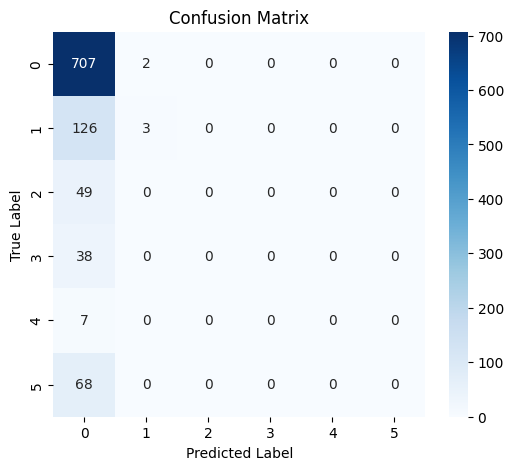

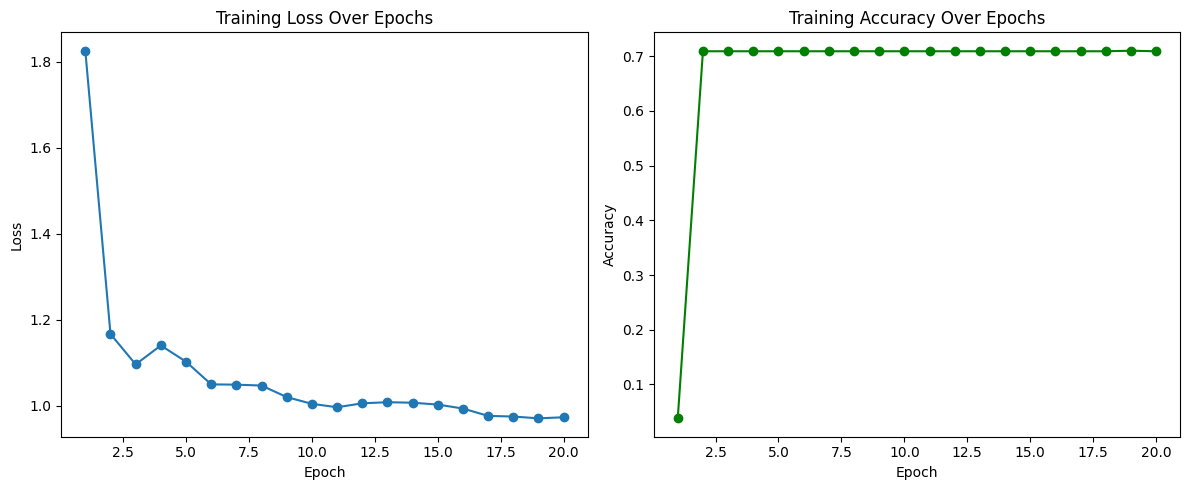

In [130]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Assuming the following variables are available from your training:
# - model: your trained HGNNClassifier model
# - node_features: torch.tensor of shape [num_samples, feature_dim]
# - labels_tensor: true labels (torch.tensor)
# - device: computation device ("cpu" or "cuda")
# And we assume training_loss and training_acc lists were collected during training

# For this demo, we'll create dummy training_loss and training_acc lists.
# Replace these with the actual ones you collected.
training_loss = [1.8251, 1.1665, 1.0959, 1.1399, 1.1022, 1.0495, 1.0488, 1.0467, 1.0199, 1.0042,
                 0.9963, 1.0054, 1.0080, 1.0068, 1.0025, 0.9933, 0.9762, 0.9747, 0.9705, 0.9730]
training_acc = [0.0380, 0.7090, 0.7090, 0.7090, 0.7090, 0.7090, 0.7090, 0.7090, 0.7090, 0.7090,
                0.7090, 0.7090, 0.7090, 0.7090, 0.7090, 0.7090, 0.7090, 0.7090, 0.7100, 0.7090]

# ---------------------------
# Evaluation on the Dataset
# ---------------------------
model.eval()
with torch.no_grad():
    outputs = model(node_features, H, Dv_inv_sqrt, De_inv)
    _, preds = torch.max(outputs, 1)

# Convert predictions and true labels to numpy arrays for scikit-learn
y_true = labels_tensor.cpu().numpy()
y_pred = preds.cpu().numpy()

# ---------------------------
# Print Evaluation Metrics
# ---------------------------
print("Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# ---------------------------
# Plot Confusion Matrix
# ---------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ---------------------------
# Plot Training Loss and Accuracy Curves
# ---------------------------
epochs = np.arange(1, len(training_loss) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs, training_acc, marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.tight_layout()
plt.show()

# ---------------------------
# If Binary Classification: Plot ROC Curve
# ---------------------------
if len(np.unique(y_true)) == 2:
    # Get probability scores for the positive class
    probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
